# Pre-processing
Notebook to explore the pre-processing of the data.

In [57]:
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
import nltk # To download
import re
from nltk.corpus import stopwords
nltk.download('stopwords') # For stop words
nltk.download('wordnet') # For POS 
nltk.download('averaged_perceptron_tagger') # For POS tagging
stop_words = set(stopwords.words('english'))
stop_words.add('')
stop_words.remove('no')
stop_words.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adelliinaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adelliinaa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adelliinaa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [59]:
data = pd.read_csv('../data/stanfordSentimentTreebank/dictionary.txt', sep='|', index_col=1)
train_test = pd.read_csv('../data/stanfordSentimentTreebank/sentiment_labels.txt', sep='|', index_col=0)

#data.rename(columns={0: 'phrase_ids', 1: 'phrase'})
data.columns = ['phrase_tokens']
data.index.names = ['phrase_id']
train_test.columns = ['sentiment_value']
train_test.index.names = ['phrase_id']


In [60]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

def get_pos_from_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def pre_processing(collection):
    # Case-fold
    collection = collection.lower()
    
    # Tokenising, converts all non-chars, new-lines and tabs to ' '
    collection = list(filter(None, re.sub(r'[\W]', ' ',collection).split(' ')))
    collection = pos_tag(collection)
    
    # Stemming and Stopping 
    return [lemmatizer.lemmatize(term[0], pos = get_pos_from_tag(term[1])) for term in collection if term[0] not in stop_words] 

#pre_processing("This is a test sentence I love this film it's good. better than the last one, greater than the second one it was playing plays played")


In [61]:
# Apply pre_processing to data

data['phrase_tokens'] = data['phrase_tokens'].apply(pre_processing)

In [62]:
# Remove empty phrases 

for index, row in data.iterrows():
    if len(row[0]) == 0:
        data = data.drop([index], axis=0)

In [63]:
# Inner Join on phrase_id

labelled_phrases = pd.merge(data, train_test, left_index=True, right_index=True)
labelled_phrases = labelled_phrases.sort_index(ascending=True)

In [9]:

#UNCOMMENT FOR BINARY CLASIFICATION
conditions = [
    (labelled_phrases['sentiment_value'] >= 0) & (labelled_phrases['sentiment_value'] <= 0.55),
    (labelled_phrases['sentiment_value'] > 0.55) & (labelled_phrases['sentiment_value'] <= 1)]
values = ['negative', 'positive']
labelled_phrases['sentiment'] = np.select(conditions, values)


In [64]:
# create a list of our conditions
conditions = [
    (labelled_phrases['sentiment_value'] >= 0) & (labelled_phrases['sentiment_value'] <= 0.2),
    (labelled_phrases['sentiment_value'] > 0.2) & (labelled_phrases['sentiment_value'] <= 0.4),
    (labelled_phrases['sentiment_value'] > 0.4) & (labelled_phrases['sentiment_value'] <= 0.6),
    (labelled_phrases['sentiment_value'] > 0.6) & (labelled_phrases['sentiment_value'] <= 0.8),
    (labelled_phrases['sentiment_value'] > 0.8) & (labelled_phrases['sentiment_value'] <= 1)
    ]

# create a list of the values we want to assign for each condition
values = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']

# create a new column and use np.select to assign values to it using our lists as arguments
labelled_phrases['sentiment'] = np.select(conditions, values)


In [65]:
labelled_phrases.to_csv('labelled_phrases.csv', index=True)
labelled_phrases.head()

,phrase_tokens,sentiment_value,sentiment
phrase_id,,,
3,[cockettes],0.50000,neutral
4,[cockettes],0.42708,neutral
5,"[cockettes, provide, window, subculture, hell,...",0.37500,negative
6,"[cockettes, provide, window, subculture, hell,...",0.41667,neutral
7,"[cockettes, provide, window, subculture, hell,...",0.54167,neutral


Text(0, 0.5, 'Label')

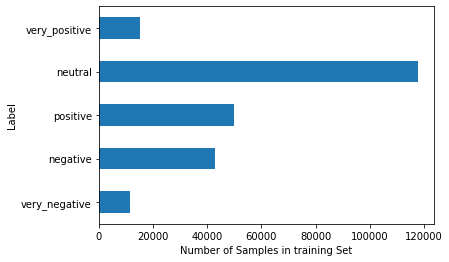

In [67]:
import matplotlib.pyplot as plt
ax = labelled_phrases["sentiment"].value_counts(sort=False).plot(kind="barh")
ax.set_xlabel("Number of Samples in training Set")
ax.set_ylabel("Label")

In [68]:
data = pd.read_csv('labelled_phrases.csv')
data = data.drop(columns=['phrase_id', 'sentiment_value'])

In [69]:
data

,phrase_tokens,sentiment
0,['cockettes'],neutral
1,['cockettes'],neutral
2,"['cockettes', 'provide', 'window', 'subculture...",negative
3,"['cockettes', 'provide', 'window', 'subculture...",neutral
4,"['cockettes', 'provide', 'window', 'subculture...",neutral
...,...,...
237439,"['standard', 'hollywood', 'bio', 'pic']",negative
237440,"['typical', 'fish', 'water', 'story']",negative
237441,['zero'],negative
237442,"['zippy', 'jazzy', 'score']",very_positive


In [70]:
reviews = np.array(data['phrase_tokens'])
sentiments = np.array(data['sentiment'])

# build train and test datasets
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews, sentiments , test_size=0.20,  random_state=0)


In [29]:
!pip install flair

from flair.embeddings import FlairEmbeddings, BertEmbeddings, WordEmbeddings, DocumentRNNEmbeddings

# init Flair embeddings
flair_forward_embedding = FlairEmbeddings('multi-forward')
flair_backward_embedding = FlairEmbeddings('multi-backward')

# init BERT base (cases)
optional_embedding = BertEmbeddings('bert-base-cased')
# OR init ELMo (original)
# optional_embedding = ELMoEmbeddings('original')

word_embeddings = list(filter(None, [
    optional_embedding,
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]))

# Initialize document embedding by passing list of word embeddings
document_embeddings = DocumentRNNEmbeddings(
    word_embeddings,
    hidden_size=512,
    reproject_words=True,
    reproject_words_dimension=256,
)

     |████████████████████████████████| 284 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 19.7 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 788 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 2.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 108.9 MB 259 kB/s eta 0:00:01    |███████████████▏                | 51.4 MB 3.0 MB/s eta 0:00:20
     |████████████████████████████████| 981 kB 923 kB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 862 kB 639 kB/s eta 0:00:01     |████████████████▍               | 440 kB 543 kB/s et

  Created wheel for segtok: filename=segtok-1.5.10-py3-none-any.whl size=25018 sha256=40b65953834d7746be1885f0575007f0b0898c92c5b4bbeb213d3664b5528b0e
  Stored in directory: /Users/adelliinaa/Library/Caches/pip/wheels/36/6d/90/6d9b11ba404f68f340ef3f6060cfdf9c9f34653b08eceeacf6
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9681 sha256=00a2bdd1c8699618275c546d850028ac4af0b62bacd13cc68572e5417c6337c8
  Stored in directory: /Users/adelliinaa/Library/Caches/pip/wheels/e2/62/1e/926d1ebe7b1e733c78d627fd288d01b83feaf67efc06e0e4c3
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993190 sha256=9c86cb2634b380723bd0a3da4c2ce64184074b48e863686174d1d0ed024a47ea
  Stored in directory: /Users/adelliinaa/Library/Caches/pip/wheels/1e/80/23/0a24928ec3a3906ff5027f38d2fea824e7e97f2ba7c83d91e3
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-py3-none-any.whl size=14376 sha256=ba70398db1ce3805e420020005ac7cc57ced9cc1411dcde9dae9c63fb65c1647
  S

100%|██████████| 172513724/172513724 [06:04<00:00, 472898.74B/s] 

2021-04-13 20:20:05,149 copying /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmpekb2gwy_ to cache at /Users/adelliinaa/.flair/embeddings/lm-jw300-forward-v0.1.pt


2021-04-13 20:20:05,344 removing temp file /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmpekb2gwy_
2021-04-13 20:20:06,176 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/lm-jw300-backward-v0.1.pt not found in cache, downloading to /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmpaz3ait_y


100%|██████████| 172513724/172513724 [08:16<00:00, 347407.37B/s] 

2021-04-13 20:28:22,960 copying /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmpaz3ait_y to cache at /Users/adelliinaa/.flair/embeddings/lm-jw300-backward-v0.1.pt


2021-04-13 20:28:23,058 removing temp file /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmpaz3ait_y


<ipython-input-29-33aa0f2a0b37>:10: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  optional_embedding = BertEmbeddings('bert-base-cased')



2021-04-13 20:40:55,183 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-forward-0.4.1.pt not found in cache, downloading to /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmp024fzbqr


100%|██████████| 73034624/73034624 [00:31<00:00, 2314710.91B/s]

2021-04-13 20:41:26,976 copying /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmp024fzbqr to cache at /Users/adelliinaa/.flair/embeddings/news-forward-0.4.1.pt
2021-04-13 20:41:27,011 removing temp file /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmp024fzbqr


2021-04-13 20:41:27,359 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/news-backward-0.4.1.pt not found in cache, downloading to /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmp2znxdhca


100%|██████████| 73034575/73034575 [00:29<00:00, 2502368.00B/s]

2021-04-13 20:41:56,800 copying /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmp2znxdhca to cache at /Users/adelliinaa/.flair/embeddings/news-backward-0.4.1.pt


2021-04-13 20:41:56,836 removing temp file /var/folders/pq/t04fqz7n1c96gclr_9nxrz900000gn/T/tmp2znxdhca


In [33]:
class Base:
    """Base class that houses common utilities for reading in test data
    and calculating model accuracy and F1 scores.
    """
    def __init__(self) -> None:
        pass

    def read_data(self, fname: str, lower_case: bool=False,
                  colnames=['sentiment', 'text']) -> pd.DataFrame:
        "Read in test data into a Pandas DataFrame"
        df = pd.read_csv(fname, sep='\t', header=None, names=colnames)
        df['sentiment'] = df['sentiment'].str.replace('__label__', '')
        # Categorical data type for truth labels
        df['sentiment'] = df['sentiment'].astype(int).astype('category')
        # Optional lowercase for test data (if model was trained on lowercased text)
        if lower_case:
            df['text'] = df['text'].str.lower()
        return df

    def accuracy(self, df: pd.DataFrame) -> None:
        "Prediction accuracy (percentage) and F1 score"
        acc = accuracy_score(df['truth'], df['pred'])*100
        f1 = f1_score(df['truth'], df['pred'], average='macro')
        print("Accuracy: {}\nMacro F1-score: {}".format(acc, f1))

In [ ]:
read_data()

In [34]:
class FlairSentiment(Base):
    """Predict fine-grained sentiment scores using Flair."""
    def __init__(self, model_file: str=None) -> None:
        super().__init__()
        from flair.models import TextClassifier
        self.model = TextClassifier.load(model_file)

    def score(self, text: str) -> int:
        from flair.data import Sentence
        doc = Sentence(text)
        self.model.predict(doc)
        pred = int(doc.labels[0].value)
        return pred

    def predict(self, train_file: None, test_file: str, lower_case: bool) -> pd.DataFrame:
        "Use tqdm to display model prediction status bar"
        from tqdm import tqdm
        tqdm.pandas()
        df = self.read_data(test_file, lower_case)
        df['pred'] = df['text'].progress_apply(self.score)
        return df

In [72]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)


# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (189955, 105660)  Test features shape: (47489, 105660)
TFIDF model:> Train features shape: (189955, 105660)  Test features shape: (47489, 105660)


In [73]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
svm = SGDClassifier(loss='hinge', l1_ratio=0.15, max_iter=1000, n_jobs=4, random_state=101)

In [74]:
def display_classification_report(true_labels, predicted_labels, target_names):

    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
         
        
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)


def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions 


In [75]:
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr, 
                                         train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                  target_names=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'])


/Users/adelliinaa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance metrics:
------------------------------
Accuracy:  65.78% 
Precision: 64.47% 
Recall:    65.78% 
F1 Score:  64.45% 

Model Classification report:
------------------------------
               precision    recall  f1-score   support

very_negative       0.58      0.46      0.52      8592
     negative       0.71      0.85      0.77     23569
      neutral       0.60      0.51      0.55     10023
     positive       0.52      0.35      0.42      2252
very_positive       0.59      0.42      0.49      3053

     accuracy                           0.66     47489
    macro avg       0.60      0.52      0.55     47489
 weighted avg       0.64      0.66      0.64     47489



In [76]:
# RESULTS FOR BINARY CLASSIFICATION
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr, 
                                         train_features=cv_train_features[:-37000], train_labels=train_sentiments[:-37000],
                                         test_features=cv_test_features[-37000:], test_labels=test_sentiments[-37000:])
display_model_performance_metrics(true_labels=test_sentiments[-37000:], predicted_labels=lr_bow_predictions,
                                  target_names=['negative', 'positive'])

/Users/adelliinaa/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance metrics:
------------------------------
Accuracy:  64.97% 
Precision: 63.58% 
Recall:    64.97% 
F1 Score:  63.50% 

Model Classification report:
------------------------------


ValueError: Number of classes, 5, does not match size of target_names, 2. Try specifying the labels parameter

In [78]:
svm_bow_predictions = train_predict_model(classifier=svm, 
                                          train_features=cv_train_features[:-37000], train_labels=train_sentiments[:-37000],
                                          test_features=cv_test_features[-37000:], test_labels=test_sentiments[-37000:])
print('SVM results with Bow:')
display_model_performance_metrics(true_labels=test_sentiments[-37000:], predicted_labels=svm_bow_predictions,
                                 target_names=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'])


svm_tfidf_predictions = train_predict_model(classifier=svm, 
                                            train_features=tv_train_features[:-37000], train_labels=train_sentiments[:-37000],
                                            test_features=tv_test_features[-37000:], test_labels=test_sentiments[-37000:])
print('-'*60)
print('\nSVM results with TF-IDF:')
display_model_performance_metrics(true_labels=test_sentiments[-37000:], predicted_labels=svm_tfidf_predictions,
                                  target_names=['very_negative', 'negative', 'neutral', 'positive', 'very_positive'])

SVM results with Bow:
Model Performance metrics:
------------------------------
Accuracy:  61.70% 
Precision: 60.44% 
Recall:    61.70% 
F1 Score:  58.20% 

Model Classification report:
------------------------------
               precision    recall  f1-score   support

very_negative       0.57      0.30      0.39      6677
     negative       0.63      0.91      0.75     18326
      neutral       0.59      0.36      0.44      7804
     positive       0.54      0.29      0.38      1777
very_positive       0.59      0.38      0.46      2416

     accuracy                           0.62     37000
    macro avg       0.58      0.45      0.48     37000
 weighted avg       0.60      0.62      0.58     37000

------------------------------------------------------------

SVM results with TF-IDF:
Model Performance metrics:
------------------------------
Accuracy:  52.69% 
Precision: 53.38% 
Recall:    52.69% 
F1 Score:  41.94% 

Model Classification report:
------------------------------
   

In [57]:
svm_bow_predictions = train_predict_model(classifier=svm, 
                                          train_features=cv_train_features, train_labels=train_sentiments,
                                          test_features=cv_test_features, test_labels=test_sentiments)
print('SVM results with Bow:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                 target_names=['negative', 'positive'])


svm_tfidf_predictions = train_predict_model(classifier=svm, 
                                            train_features=tv_train_features, train_labels=train_sentiments,
                                            test_features=tv_test_features, test_labels=test_sentiments)
print('-'*60)
print('\nSVM results with TF-IDF:')
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                  target_names=['negative', 'positive'])

SVM results with Bow:
Model Performance metrics:
------------------------------
Accuracy:  80.56% 
Precision: 81.36% 
Recall:    80.56% 
F1 Score:  79.47% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.94      0.86     30021
    positive       0.85      0.57      0.68     17468

    accuracy                           0.81     47489
   macro avg       0.82      0.76      0.77     47489
weighted avg       0.81      0.81      0.79     47489

------------------------------------------------------------

SVM results with TF-IDF:
Model Performance metrics:
------------------------------
Accuracy:  73.44% 
Precision: 77.15% 
Recall:    73.44% 
F1 Score:  69.43% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.71      0.97      0.82     30021
    positive       0.87      0.33      0.47     17468

    accura